### Import packages

In [1]:
# import dva_sdhdf_combine
import imp
import os
import subprocess
import h5py
import numpy as np
from astropy.time import Time
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import HourLocator as HourLocator
from matplotlib.dates import MinuteLocator as MinuteLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy import units as u
from astropy.time import TimeDelta
from ipywidgets import interact
import matplotlib.patches as patches


#### Change the directory to where the files are located" ####
day ='25'
directory = '../DVA/Data_Files/DVA_Day_Surveys/'

### Change the scan details to your current scan
# df = 0.5        
# dt = 6.9444431574083865e-06

#TODO: actually do the scan properties definition in the beginning
##############################################################

### Read in the file listing azimuth scan start and stop times:

In [2]:
scan_id = []    # The scan id number
scan_start = []  # Start time of the scan (UTC)
scan_stop = []   # Stop time of the scan (UTC)

# Read in the data and store it in arrays:
with open(directory+'DVAsurvey_phase1_day0'+day+'.txt') as fp:
    for line in fp:       
        scan_id.append(int(line.split()[0]))
        scan_start.append(line.split()[1]+'T'+line.split()[2][0:12])
        scan_stop.append(line.split()[3]+'T'+line.split()[4][0:12])
        
# Print out the scan numbers with their start and stop times:
for i in range(0,len(scan_id)):
    print(f"{scan_id[i]:04}",scan_start[i],scan_stop[i])

# Convert start and stop times to Modified Julian Day (MJD).
# This is needed for plotting and for selecting out data collected
# between particular times:
scan_start_mjd = Time(scan_start, format='isot',scale='utc').mjd
scan_stop_mjd  = Time(scan_stop,  format='isot',scale='utc').mjd


1052 2022-07-04T03:57:53.110 2022-07-04T04:15:55.184
2565 2022-07-04T04:20:37.406 2022-07-04T04:38:39.310
2566 2022-07-04T04:40:22.266 2022-07-04T04:58:24.003
1271 2022-07-04T05:03:42.716 2022-07-04T05:21:44.818
1272 2022-07-04T05:23:27.291 2022-07-04T05:41:29.292
2857 2022-07-04T05:48:35.269 2022-07-04T06:06:37.317
0124 2022-07-04T06:11:19.190 2022-07-04T06:29:21.101
1637 2022-07-04T06:34:03.920 2022-07-04T06:52:06.005
0342 2022-07-04T06:57:23.897 2022-07-04T07:15:25.930
1927 2022-07-04T07:21:55.804 2022-07-04T07:39:58.034
1928 2022-07-04T07:42:16.530 2022-07-04T08:00:18.319
2001 2022-07-04T08:03:48.814 2022-07-04T08:21:51.062
2002 2022-07-04T08:24:09.373 2022-07-04T08:42:11.545
2075 2022-07-04T08:45:41.821 2022-07-04T09:03:44.188
2148 2022-07-04T09:07:50.625 2022-07-04T09:25:52.832
2149 2022-07-04T09:27:35.229 2022-07-04T09:45:37.044
2150 2022-07-04T09:47:56.026 2022-07-04T10:05:57.828
2151 2022-07-04T10:07:40.752 2022-07-04T10:25:42.662
2152 2022-07-04T10:27:25.410 2022-07-04T10:45:

## Read in scan files and stich them together:

In [3]:
t_set = []
az_set = []
dec_set = []
ra_set = []
el_set = []
noise_set = []
trim_flag = []

scan0 = f"{scan_id[0]:04}"

# Use one of the scans to get the list of frequencies:
freq_channel_increment = 12 #TODO: I'll have to change this to 1 once I am sure I'm reading the data correctly

file = h5py.File(directory+'dva_survey_raw_scan_'+scan0+'.h5','r')
freq = file['data']['beam_0']['band_SB0']['frequency'][::freq_channel_increment]/1e6
df = freq[1] - freq[0]

# Create empty arrays for the power data:
RR_set = np.empty([0,len(freq)])
LL_set = np.empty([0,len(freq)])
reRL_set = np.empty([0,len(freq)])
imRL_set = np.empty([0,len(freq)])

# Loop through all the scans in the "scan_num" list:
for i in scan_id[0:5]:
    print(i)
    # select the file:
    file = h5py.File(directory+'dva_survey_raw_scan_'+f"{i:04}"+'.h5','r')
    print(file)
    
    # access the correct location in the file structure:
    dataset = file['data']['beam_0']['band_SB0']['scan_0']
    
    # Add the position and time data to the corresponding arrays:
    dec_set = np.concatenate([dec_set,dataset['metadata']['declination']])
    ra_set = np.concatenate([ra_set,dataset['metadata']['right_ascension']])
    el_set = np.concatenate([el_set,dataset['metadata']['elevation']])
    az_set = np.concatenate([az_set,dataset['metadata']['azimuth']])
    t_set = np.concatenate([t_set,dataset['metadata']['utc']])
    noise_set = np.concatenate([noise_set,dataset['metadata']['noise_state']]) #This is a "mask" for noise regions 1 = noise 0=all good
    trim_flag = np.concatenate([trim_flag,dataset['metadata']['trim_scan_flag']])
    
    # Add the spectrometer power data to the corresponding arrays:
    RR_set = np.concatenate([RR_set,dataset['data'][:,0,::freq_channel_increment]],axis=0)
    LL_set = np.concatenate([LL_set,dataset['data'][:,1,::freq_channel_increment]],axis=0)
    reRL_set = np.concatenate([reRL_set,dataset['data'][:,2,::freq_channel_increment]],axis=0)
    imRL_set = np.concatenate([imRL_set,dataset['data'][:,3,::freq_channel_increment]],axis=0)
    
t_plt = Time(t_set, format='isot',scale='utc').mjd

1052
<HDF5 file "dva_survey_raw_scan_1052.h5" (mode r)>
2565
<HDF5 file "dva_survey_raw_scan_2565.h5" (mode r)>
2566
<HDF5 file "dva_survey_raw_scan_2566.h5" (mode r)>
1271
<HDF5 file "dva_survey_raw_scan_1271.h5" (mode r)>
1272
<HDF5 file "dva_survey_raw_scan_1272.h5" (mode r)>


### Polarized Intensity

In [4]:
polarized = []
for i,j in zip(reRL_set,imRL_set):
    PI = np.sqrt((i**2)+(j**2))
    polarized.append(PI)
polarized_set = np.array(polarized)

# NEW RFI_Excision functions (WORK IN PROGRESS)

In [5]:
# power_array has time and frequency
#TODO: Count how long it takes to run this for a single frequency 

# def Find_Slope(array, idx):
#     return array[idx+2] - array[idx]
def Find_Slope(y_array, x_array, idx):
    return (y_array[idx+2] - y_array[idx])/(x_array[idx+2] - x_array[idx])

def Is_Time_RFI(in_power_array, threshold, idx, interval_start, interval_end):
    retVal = False
    in_power_mean = np.nanmean(in_power_array[interval_start:interval_end])
    in_power_std = np.nanstd(in_power_array[interval_start:interval_end])
    if abs(in_power_array[idx]) > abs(in_power_mean)+threshold*in_power_std:
        retVal = True
    return retVal



def Get_RFI_Duration(time_array, in_power_array, interval_start, interval_end):  #NOTE: This approach might have issues if the interval has a nan on it
    #Find the first slope
    first_slope = Find_Slope(in_power_array, time_array, interval_start)
    #Initiate the RFI interval indexes at the boundaries of the set
    RFI_start = interval_start
    RFI_end = interval_end
    #Initiate as the fastest rise & fall
    steepest_rise = first_slope
    steepest_fall = first_slope 
    start_idx = interval_start + 1  # Ignores the first slope (since it's already calculated)
    end_idx = interval_end - 2      # Avoids overflowing (since each slope is calculated 2 indexes ahead)
    for idx in range(start_idx, end_idx):
        current_slope = Find_Slope(in_power_array, time_array, idx)
        if(current_slope >  steepest_rise):
            steepest_rise = current_slope
            RFI_start = idx
        elif(current_slope < steepest_fall):
            steepest_fall = current_slope
            RFI_end = idx + 2
    return (RFI_end - RFI_start)

#TODO: Change the name of the function below to Find_RFI_Excision_Regions, or make a wrapper function to go through all the frequencies

# def Get_RFI_Excision_Mask(time_array, power_array, time_steps, slope_threshold, starting_frequency): #TODO: The final function will not take starting_frequency as an input, I'll loop through all frequencies
#     confirmed_RFI_events = Find_RFI_Excision_Intervals(time_array, power_array, time_steps, slope_threshold, starting_frequency)
#     mask = []
#     #TODO: Populate mask
#     return mask
def RFI_Time_Scan(time_array, single_freq_power_array, time_steps, threshold):
    possible_RFI_events = []
    start_idx = time_steps
    end_idx = len(time_array)-time_steps              
    for idx in range(start_idx, end_idx):
        if Is_Time_RFI(single_freq_power_array, threshold, idx, idx - time_steps, idx + time_steps):
            RFI_duration = Get_RFI_Duration(time_array, single_freq_power_array, idx - time_steps, idx + time_steps)
            possible_RFI_events.append([idx, RFI_duration])
    return(possible_RFI_events)

def Spectrum_RFI_Start_Found(time_array, spectrum_power_array, idx, slope_threshold):
    RFI_Start_Found = False
    spectrum_gradient = np.gradient(spectrum_power_array)
    current_slope = spectrum_gradient[idx-1]              #Find_Slope(spectrum_power_array, time_array, idx)
    next_slope = spectrum_gradient[idx]#Find_Slope(spectrum_power_array, time_array, idx+3)
    if((current_slope <= slope_threshold) and (next_slope >= slope_threshold)):
        RFI_Start_Found = True
        print("RFI start information:\n - current slope:", current_slope,"next slope:", next_slope, "Slope threshold:", slope_threshold)
    return RFI_Start_Found

def Spectrum_RFI_End_Found(time_array, spectrum_power_array, idx, slope_threshold):
    RFI_End_Found = False
    spectrum_gradient = np.gradient(spectrum_power_array)
    current_slope = spectrum_gradient[idx-1]            #Find_Slope(spectrum_power_array, time_array, idx)
    next_slope = spectrum_gradient[idx]           #Find_Slope(spectrum_power_array, time_array, idx+3)
    if((current_slope <= (-1)*slope_threshold) and (next_slope >= (-1)*slope_threshold)):
        RFI_End_Found = True
        print("RFI end information:\n - current slope:", current_slope,"next slope:", next_slope, "Slope threshold:", slope_threshold)
    return RFI_End_Found

def RFI_Spectrum_Scan(time_array, spectrum_power_array, freq_idx, slope_threshold): #NOTE: This might be an issue if I have a nan value on my array
    scan_bandwidth = 50 #[MHz]
    start_idx = int(freq_idx - int((scan_bandwidth/df)/2))  #This changes the bandwidth from MHz to idxes
    end_idx = int(freq_idx + int((scan_bandwidth/df)/2))
    RFI_confirmed = False
    RFI_spectral_thickness = 0
    for rfi_start_idx in range(start_idx, end_idx):                                             #Scan over the entire bandwith interval
        if(Spectrum_RFI_Start_Found(time_array, spectrum_power_array, rfi_start_idx, slope_threshold)):     #If I found the starting pattern
            for rfi_end_idx in range(rfi_start_idx, end_idx):                                   #Finish looking at the bandwidth interval looking for the end
                if(Spectrum_RFI_End_Found(time_array, spectrum_power_array, rfi_end_idx, slope_threshold)):     #If I found the ending pattern          TODO: I have a problem in the end found algorithm
                    RFI_confirmed = True      
                    print("inner")                                                          #If there's a start and end, I'll confirm that event as RFI
                    break
                    # RFI_spectral_thickness = (rfi_end_idx - rfi_start_idx)
                else:
                    continue
            if(RFI_confirmed):                                                                          #and stop looping throught the interval for efficiency
                break
        else:
            rfi_end_idx = end_idx
    return RFI_confirmed, rfi_start_idx, (rfi_end_idx)#RFI_spectral_thickness
    
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def Find_RFI_Regions(time_array, power_array, time_steps, slope_threshold, starting_frequency):
    confirmed_RFI_events = []
    # mask = np.zeros([len(time_array)])  #Initiate empty mask
    # freq_measured = np.min(np.where(abs(freq-starting_frequency)<df))#[0][0] #[MHz]
    freq_idx = find_nearest_idx(freq, starting_frequency)
    freq_measured = freq[freq_idx]
    print("input starting frequency:", starting_frequency)
    print("closest frequency measured:", freq_measured)
    
    gaussian_threshold = 4  #Arbitrary, changed as needed
    possible_RFI_events = RFI_Time_Scan(time_array, power_array[:, freq_idx], time_steps, gaussian_threshold) #Returns an array with [idx, RFI_idx_duration] of candidate RFI signals
    print("possible RFI events:", len(possible_RFI_events))
    for event in range(len(possible_RFI_events)):
        dt = (time_array[1] - time_array[0])
        RFI_event_time_idx = possible_RFI_events[event][0]              #in [idxes]
        RFI_event_duration = possible_RFI_events[event][1]*(dt)         #in [time_units]
        #Confirms by doing a small spectrum scan
        RFI_event_confirmation_result = RFI_Spectrum_Scan(time_array, power_array[RFI_event_time_idx, :], freq_idx, slope_threshold) #Returns [bools, rfi_start_idx, rfi_end_idx]_______________old:[bool, rfi_start_idx, idx_spectral_thickness]
        print("RFI", event ,"starts at:", freq[RFI_event_confirmation_result[1]],"ends at:", freq[RFI_event_confirmation_result[2]])
        if(RFI_event_confirmation_result[0]):
            print("RFI", event, "was confirmed")
            # confirmed_RFI_events.append([freq_measured, RFI_event_confirmation_result[1]*df, time_array[possible_RFI_events[event][0]], RFI_event_duration])
            confirmed_RFI_events.append([freq[RFI_event_confirmation_result[1]], (RFI_event_confirmation_result[2] - RFI_event_confirmation_result[1])*df, time_array[possible_RFI_events[event][0]], RFI_event_duration])
            #TODO: Run the RFI_Spectrum_Scan_Sweep to find the borders of the RFI duration
    print("confirmed RFI events:", len(confirmed_RFI_events))
    return confirmed_RFI_events #An Array with [freq, df, time, dt] for each confirmed RFI

###################################################################################################################################################################
# in_power_array        Input power array (RR, LL, reRL, imRL) at a single frequency TODO: This needs to change to 
# numt                  Number of time points to include in the 'window' in which the standard deviation is calculated
# threshold             Array of standard deviation thresholds to use in each stage of the RFI excision 

def Get_Polarized_Set(reRL_set, imRL_set, freq_measured):
    polarized = []
    reRL_set_in_use = reRL_set[:,freq_measured]    #TODO: maybe I can try making something general that I can scan over all frequencies
    imRL_set_in_use = imRL_set[:,freq_measured]
    for i,j in zip(reRL_set_in_use,imRL_set_in_use):
        PI = np.sqrt((i**2)+(j**2))
        polarized.append(PI)
    return np.array(polarized)


def Apply_RFI_Excision_Mask(mask, input_array): #TODO: This needs to be updated to implement all frequencies
    
    masked_copy = input_array.copy()
    for idx in range(0, len(input_array)-1):
        if(mask[idx] == 1):
            masked_copy[idx] = np.nan
    return(masked_copy)



In [6]:
df = freq[1]-freq[0]

def DVA_Waterfall_View():
    #TODO: Add another DVA_Waterfall interactive_function such that I can change between LL_Set, RR_set, etc...
    power_min = 70
    power_max = 78

    fig,axs = plt.subplots(1,1,figsize=(15,10)) 
    fs = 16

    im = axs.imshow(10.*np.log10(LL_set.T),aspect='auto',vmin=power_min,vmax=power_max,origin='lower',
                extent=[t_plt[0],t_plt[-1],freq[0],freq[-1]])

    divider = make_axes_locatable(axs)
    cax = divider.append_axes('right', size='2%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=fs) 
    cbar.set_label('Power (dB)', fontsize=fs)

    axs.set_xlim(t_plt[0],t_plt[-1])
    axs.set_ylim(freq[0],freq[-1])
    axs.tick_params(axis='both', labelsize=fs)
    axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axs.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
    axs.set_xlabel('Time (UTC)',fontsize=fs)        
    axs.set_ylabel('Frequency (MHz)',fontsize=fs)


def DVA_Cross_Sections(freq_chosen, time_idx, freq_cross_section):
    freq_measured = np.where(abs(freq-freq_chosen)<df)[0][0]

    fs = 12    
    fig,axs1 = plt.subplots(1,1,figsize=(16,6))  
    # TODO: use the log of LL_set_clean
    if(freq_cross_section):
        axs1.plot(freq, LL_set[time_idx,:], label = 'LL_set with polarized mask')
        axs1.vlines(freq_chosen, 0 , 100e9, color = 'red')
        axs1.set_ylim(np.min(LL_set[:,freq_measured]), np.max(LL_set[time_idx,:]))
        axs1.set_xlabel('Frequency',fontsize=fs)
        axs1.set_ylabel('Power',fontsize=fs)
    else:
        axs1.plot(t_plt, LL_set[:,freq_measured], label = 'LL_set unmasked RFI')
        axs1.vlines(t_plt[time_idx], 0 , 100e9, color = 'red')

        axs1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        axs1.set_ylim(np.min(LL_set[:,freq_measured]), np.max(LL_set[:,freq_measured]))
        axs1.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
        axs1.set_xlabel('Time (UTC)',fontsize=fs)
        axs1.set_ylabel('Power',fontsize=fs)
        axs1.legend()

def DVA_Visualization(waterfall_enabled):
    if waterfall_enabled:
        interact(DVA_Waterfall_View)
    else:
        interact(DVA_Cross_Sections, freq_chosen = (350, 1000, df), freq_cross_section = False, time_idx = (0,len(t_plt)-1))


interact(DVA_Visualization, waterfall_enabled = True)

#TODO: plot power in DB

interactive(children=(Checkbox(value=True, description='waterfall_enabled'), Output()), _dom_classes=('widget-…

<function __main__.DVA_Visualization(waterfall_enabled)>

# This is the flagging visualization

input starting frequency: 845
closest frequency measured: 844.7708333333334
possible RFI events: 14
RFI 0 starts at: 868.7708333333334 ends at: 869.7708333333334
RFI 1 starts at: 868.7708333333334 ends at: 869.7708333333334
RFI 2 starts at: 868.7708333333334 ends at: 869.7708333333334
RFI start information:
 - current slope: 1075123.5477429456 next slope: 8437386909.805951 Slope threshold: 4000000000.0
RFI end information:
 - current slope: -5617075074.690928 next slope: -94172664.06858926 Slope threshold: 4000000000.0
inner
RFI 3 starts at: 839.7708333333334 ends at: 845.7708333333334
RFI 3 was confirmed
RFI 4 starts at: 868.7708333333334 ends at: 869.7708333333334
RFI 5 starts at: 868.7708333333334 ends at: 869.7708333333334
RFI 6 starts at: 868.7708333333334 ends at: 869.7708333333334
RFI 7 starts at: 868.7708333333334 ends at: 869.7708333333334
RFI 8 starts at: 868.7708333333334 ends at: 869.7708333333334
RFI 9 starts at: 868.7708333333334 ends at: 869.7708333333334
RFI 10 starts a

Text(0, 0.5, 'Frequency (MHz)')

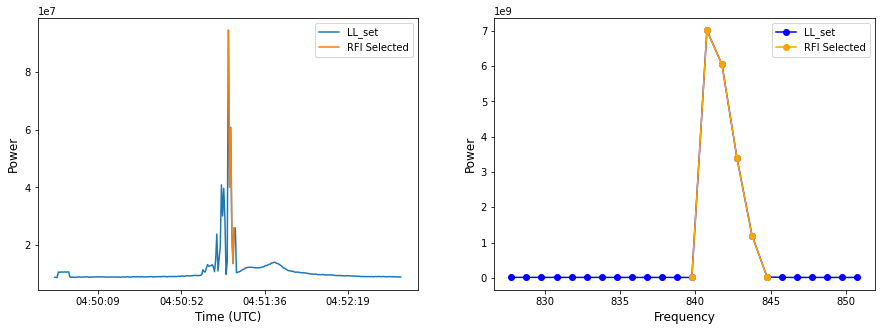

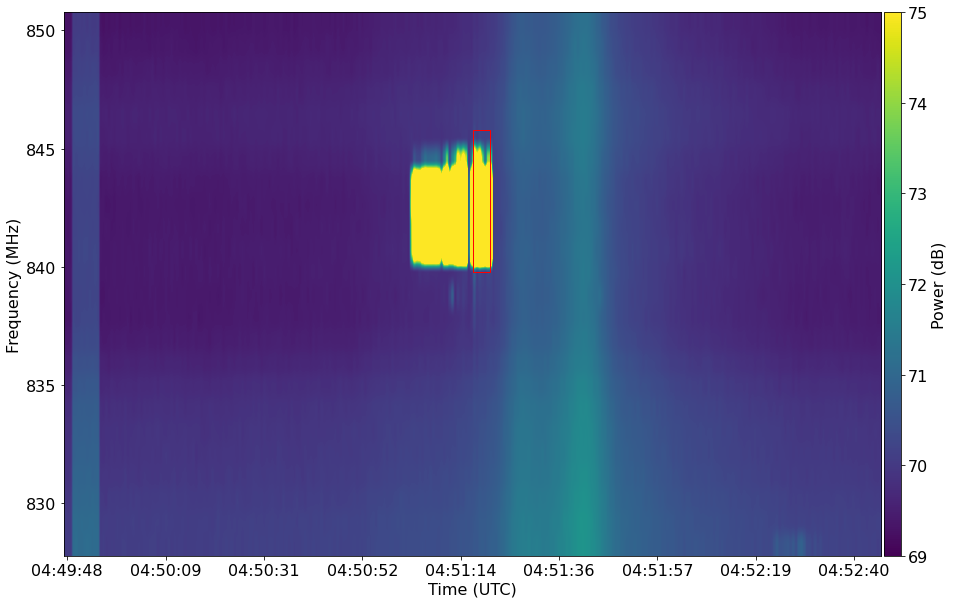

In [7]:
time_steps = 30
slope_threshold = 4e9 #This number needs to be adjusted in order to correctly filter out non-RFI NOTE: 5000 works
freq_chosen = 845
polarized_Set_RFI_Regions = Find_RFI_Regions(t_plt, polarized_set, time_steps, slope_threshold, freq_chosen) #Returns an array of [freq, df, time, dt]1
first_RFI_region = polarized_Set_RFI_Regions[0]

print("real df is:", freq[1] - freq[0])

#Try plotting the first RFI_Region

power_min = 69
power_max = 75

time_framing = 25
freq_framing = 2

t1_plt = first_RFI_region[2]# - first_RFI_region[3]
t2_plt = first_RFI_region[2] + first_RFI_region[3]
t1_plt_framed = first_RFI_region[2] - first_RFI_region[3]*time_framing
t2_plt_framed = first_RFI_region[2] + first_RFI_region[3]*time_framing

freq1 = first_RFI_region[0]# - first_RFI_region[1]
freq2 = first_RFI_region[0] + first_RFI_region[1]
freq1_framed = first_RFI_region[0] - first_RFI_region[1]*freq_framing
freq2_framed = first_RFI_region[0] + first_RFI_region[1]*freq_framing
######################################
rfi_start_idx = find_nearest_idx(t_plt, t1_plt)
rfi_end_idx = find_nearest_idx(t_plt, t2_plt)
rfi_start_idx_framed = find_nearest_idx(t_plt, t1_plt_framed)
rfi_end_idx_framed = find_nearest_idx(t_plt, t2_plt_framed)

f_plt_start_idx = find_nearest_idx(freq, freq1)
f_plt_end_idx = find_nearest_idx(freq, freq2)
f_plt_start_idx_framed = find_nearest_idx(freq, freq1_framed)
f_plt_end_idx_framed = find_nearest_idx(freq, freq2_framed)


# PLOTTING THE CROSS-SECTIONS ------------------------------------------------------------------------------------------------
freq_idx = find_nearest_idx(freq, freq_chosen)
rfi_halfway_time = int((rfi_start_idx + rfi_end_idx)/2)
fig,axs1 = plt.subplots(1,2,figsize=(15,5)) 

axs1[0].plot(t_plt[rfi_start_idx_framed: rfi_end_idx_framed], LL_set[rfi_start_idx_framed: rfi_end_idx_framed, freq_idx], label = 'LL_set')
axs1[0].plot(t_plt[rfi_start_idx: rfi_end_idx], LL_set[rfi_start_idx: rfi_end_idx, freq_idx], label = 'RFI Selected')
axs1[0].set_xlabel('Time (UTC)',fontsize=12)
axs1[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
axs1[0].set_ylabel('Power',fontsize=12)

axs1[1].plot(freq[f_plt_start_idx_framed: f_plt_end_idx_framed], LL_set[rfi_halfway_time,f_plt_start_idx_framed: f_plt_end_idx_framed], '-ok', label = 'LL_set', color = 'blue')
axs1[1].plot(freq[f_plt_start_idx: f_plt_end_idx], LL_set[rfi_halfway_time,f_plt_start_idx: f_plt_end_idx], '-ok', label = 'RFI Selected', color = 'orange')
axs1[1].set_xlabel('Frequency',fontsize=12)
axs1[1].set_ylabel('Power',fontsize=12)

axs1[0].legend()
axs1[1].legend()
#--------------------------------------------------------------------------------------------------------------------------


# PLOTTING WATERFALL RFI ------------------------------------------------------------------------------------------------------
RFI_duration_time = t_plt[rfi_start_idx_framed: rfi_end_idx_framed]
RFI_freq_bandwith = freq[f_plt_start_idx_framed: f_plt_end_idx_framed]


fig,axs = plt.subplots(1,1,figsize=(15,10)) 
fs = 16

# Create a Rectangle patch ---------------------------------------------------------------------------------------------------
RFI_detected = patches.Rectangle((t_plt[rfi_start_idx], freq[f_plt_start_idx]), t_plt[rfi_end_idx] - t_plt[rfi_start_idx], freq[f_plt_end_idx] - freq[f_plt_start_idx], linewidth=1, edgecolor='r', facecolor='none')
# Add the patch to the Axes0
axs.add_patch(RFI_detected)
# ---------------------------------------------------------------------------------------------------------------------------

im = axs.imshow(10.*np.log10(LL_set[rfi_start_idx_framed: rfi_end_idx_framed,f_plt_start_idx_framed: f_plt_end_idx_framed].T),aspect='auto',vmin=power_min,vmax=power_max,origin='lower',
            extent=[RFI_duration_time[0],RFI_duration_time[-1],RFI_freq_bandwith[0],RFI_freq_bandwith[-1]])

divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='2%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=fs) 
cbar.set_label('Power (dB)', fontsize=fs)

axs.set_xlim(RFI_duration_time[0],RFI_duration_time[-1])
# axs.set_ylim(RFI_freq_bandwith[0],RFI_freq_bandwith[-1])
axs.tick_params(axis='both', labelsize=fs)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
axs.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
axs.set_xlabel('Time (UTC)',fontsize=fs)        
axs.set_ylabel('Frequency (MHz)',fontsize=fs)


#TODO: I don't think it's clear which region this method is flaggin as RFI

# Future notes:

I think the algorighm should use primarily the frequency sweep to determine the shape of the RFI.

steps:
- Work on the frequency bandwidth algorithm
- Repeat that frequency sweep over time and use it to determine the duration of the RFI, since the "gaussian" shape of the RFI is very unreliable


### Anna's comment:
- Ignore the noise beacon using the file. There's an notebook that does that already